# The Helmholtz Equation with FEniCS

:::{note}
You can run this code directly in your browser by clicking on the rocket logo ( <i class="fas fa-rocket"></i> ) at the top of the page, and clicking 'Binder'. This will open a Jupyter Notebook in a [Binder](https://mybinder.org/) environment which is set up to contain everything you need to run the code. **Don't forget to save a local copy if you make any changes!**

If you prefer, you can download the Jupyter Notebook file to run locally, by clicking the download logo ( <i class="fas fa-download"></i> ) at the top of the page and selecting '.ipynb'.

If you are new to using Jupyter Notebooks, [this guide](https://www.dataquest.io/blog/jupyter-notebook-tutorial/) will help you get started.
:::

## Prerequisites

In order to be able to run the code presented in this tutorial you will need:

* A working Python environment for your platform. For more information, refer to [the Python website](https://www.python.org/);
* A working FEniCS installation within your Python environment. For more information, refer to [the FEniCS documentation](https://fenics.readthedocs.io/en/latest/index.html);
* The following Python packages installed in your environment:
    * `numpy`;
    * `plotly`;
    
A basic knowledge of Partial Differential Equations (PDEs) and FEM will be beneficial.


## Introduction

This tutorial cover the basics on how to solve the Helmholtz equation with Neumann boundary conditions by using FEniCS.

### The Governing PDE

#### Definitions

We use the following symbols:

* $\Omega$ denotes an open set of $\mathbb{R}^3$. $\partial \Omega$ denotes its boundary and $\overline{\Omega} \doteq \Omega \cup \partial \Omega$ it's closure. $\mathbf{x}$, a 3D vector, is the generic point in $\overline{\Omega}$.
* $T$ denotes an open interval in $\mathbb{R}$ $t$ is the generic point in $T$.
* We denote the laplace operator with $\nabla^2$.
* We denote the Euclidean inner productwith $\cdot$.

Note that we will index the components of vectors starting from $0$. This to be consistent with the Python programming language.

$$ \mathbf{x} = \begin{bmatrix} x_{0} \\ x_{1} \\ x_{2} \end{bmatrix} \in \overline{\Omega}$$ 


#### The Helmholtz Equation

The lossless wave equation reads:

$$
\nabla^2 p\left(\mathbf{x},t\right) = \frac{1}{c^2}\frac{\partial^2 p\left(\mathbf{x},t\right)}{\partial t^2}
$$

Where $p = p \left(\mathbf{x},t\right)$ is the unknown pressure disturbance field, in Pascal. $p$ is defined in $\overline{\Omega} \times T$ and has complex values. $c$ is the phase speed of sound in the medium, in meters per second.

We impose that the pressure field is a steady state harmonic field:

$$
p\left(\mathbf{x},t\right) = u\left(\mathbf{x}\right) \exp\left(j\omega t\right)
$$

Where $u$ is the unknown spatial part of the field. $u$ is defined in $\overline{\Omega}$ and has complex values. $j$ is the imaginary unit and $\omega$ is the angular frequncy of the field, in radians per second. If $\nu$ denotes the frequency in Hertz we have:

$$ \omega = 2\pi\nu = kc$$

With $k$ the wave number.

By substituting into the wave equation we obtain the Helmholtz equation:

$$
\nabla^2 u\left(\mathbf{x}\right) + k^2\left(\mathbf{x}\right) = 0
$$

This is our governing PDE.

#### Boundary Conditions

The Helmholtz equation can be completed with Dirchlet, Neumann and Robin boundary conditions:

* Dirchlet conditions are impose a specific value of $u$ on $\partial \Omega$.
* Neumann conditions specify a normal particle velocity $\partial \Omega$.
* Robin conditions specify an acoustic impedance on $\partial \Omega$ as well as an optional particle velocity.

Whilst the Dirchlet conditions are the simplest to deal with we will focus on Neumann conditions in this tutorial. This because prescription of particle velocity is the most common boundary condition for simple simulations.

Let $\partial \Omega_l$ denote a partition of $\partial \Omega$, with $l=0,1,2,\dots,L-1$, $L$ being the number of partitions. Let the complex valued function $w_l\left(\mathbf{x}\right)$ denote the prescribed normal component of the spatial part of the particle velocity field in $\partial \Omega _l$. Thanks to the Euler equation in frequency domain we have:

$$
\nabla u \left(\mathbf{x}\right) \cdot \hat{\mathbf{n}}\left(\mathbf{x}\right) = j\omega\rho w_l\left(\mathbf{x}\right) \text{ for } \mathbf{x} \in \partial \Omega_l, \space \forall \space l = 0, 1, 2, \dots, L - 1
$$

Where $\rho$ is the density of the medium and $\hat{\mathbf{n}}\left(\mathbf{x}\right)$ is the normal unit vector to $\partial \Omega$ in $\mathbf{x}$.

We are now able to prescribe normal particle velocity at each value of the boundary. To simplify notation, we define the acoustic bounday fluxes $g_l\left(\mathbf{x}\right)$ as follows:

$$
g_l\left(\mathbf{x}\right) \doteq j\omega\rho w_l\left(\mathbf{x}\right)
$$

Hence, the equation bove reads:

$$
\nabla u \left(\mathbf{x}\right) \cdot \hat{\mathbf{n}}\left(\mathbf{x}\right) = g_l\left(\mathbf{x}\right) \text{ for } \mathbf{x} \in \partial \Omega_l, \space \forall \space l = 0, 1, 2, \dots, L - 1
$$

:::{note}
Technically there is no need to partition $\partial \Omega$. One could have simply defined $w\left(\mathbf{x}\right)$ in $\partial \Omega$ and set it to the needed (eventual zero) values in the various parts of the boundary as needed. However it is easier to think in terms of partitions when working with FEniCS, as we will see.
:::

### The Weak Form

We need to convert our PDE into a weak form to solve our problem with FEniCS. This is done by recognising that $u$ is a vector of an appropriate Sobolev space. Then, another test function $\phi$ is taken from the Sobolev space, with the requirement of being $0$ on $\partial \Omega$. Multiplication of the governing PDE with $\phi$ and integration by parts lead to the weak form. The weak form reads:

$$
\int_\Omega \nabla u \cdot \nabla \phi^\star d\mathbf{x} - k^2 \int_\Omega u \phi^\star d\mathbf{x} = \sum_{l=0}^{L-1}\int_{\partial \Omega_l} g_l \phi^\star ds
$$

Where we simplified notation by dropping the functions arguments. $d\mathbf{x}$ denotes the volume element of $\Omega$ while $ds$ denotes the surface element in $\partial \Omega$. $\star$ denotes complex conjugation. Note that the equation above has the following form:

$$
a \left(u,\phi\right) = L\left(\phi\right)
$$

Where $a$ and $L$ are the bilinear and linear form respectively. FEniCS requires the specification of these two quantities.

:::{note}
The Neumann boundary conditions feature directly in the weak form. The same goes for Robin conditions. However, Dirchlet boundary conditions don't and are treated separately.
:::

### More Details

A similar tutorial is presented at the links by the same author.

* [Intro to FEniCS - Part 1](https://computational-acoustics.gitlab.io/website/posts/30-intro-to-fenics-part-1/).
* [Intro to FEniCS - Part 2 ](https://computational-acoustics.gitlab.io/website/posts/31-intro-to-fenics-part-2/).
* [Intro to FEniCS - Part 3 ](https://computational-acoustics.gitlab.io/website/posts/32-intro-to-fenics-part-3/).

This tutorial focuses more on the code, whilst the ones above focus more on the derivation of the weak form.

For more details about acoustics, FEniCS and computational methods the following books are recommended:

* [Computational Acoustics of Noise Propagation in Fluids](https://link.springer.com/book/10.1007%2F978-3-540-77448-8).
* [Solving PDEs in Python](https://link.springer.com/book/10.1007/978-3-319-52462-7).
* [Fundamentals of Acoustics](https://www.wiley.com/en-gb/Fundamentals+of+Acoustics,+4th+Edition-p-9780471847892).

## Setup

We now setup our simulation.

First, we decide the shape of $\Omega$, then the properties of the medium and then the boundary conditions.

### Domain

We choose a rectangular room with the following geometry:

| Dimension | Symbol    | Value      |
|-----------|-----------|------------|
| Length    | $d_{x_0}$ | $4$ meters |
| Width     | $d_{x_1}$ | $5$ meters |
| Height    | $d_{x_2}$ | $3$ meters |

Hence $\Omega = \left(0, d_{x_0} \right) \times \left(0, d_{x_1} \right) \times \left(0, d_{x_2} \right)$.


### Medium Properties

We choose air at room temperature:

| Property       | Symbol | Value                             |
|----------------|--------|-----------------------------------|
| Speed of Sound | $c$    | $343$ meters per second           |
| Density        | $\rho$ | $1.205$ kilograms per cubic meter |


### Boundaries

We partition $\partial \Omega$ in the $6$ walls of the room. We make $5$ of the rigid (normal particle velocity set to $0$) while we make one having uniform velocity.

| Boundary Definition                                                                      | Particle Velocity Definition     |
|------------------------------------------------------------------------------------------|---------------------------------------|
| $ \partial \Omega_0 \doteq \left\{ \mathbf{x} \in \overline{\Omega} : x_0 = 0 \right\} $ | $ w_l \left(\mathbf{x}\right) = 0 $ |
| $ \partial \Omega_1 \doteq \left\{ \mathbf{x} \in \overline{\Omega} : x_0 = d_{x_0} \right\} $ | $ w_l \left(\mathbf{x}\right) = 0 $ |
| $ \partial \Omega_2 \doteq \left\{ \mathbf{x} \in \overline{\Omega} : x_1 = 0 \right\} $ | $ w_l \left(\mathbf{x}\right) = 10 $ |
| $ \partial \Omega_3 \doteq \left\{ \mathbf{x} \in \overline{\Omega} : x_1 = d_{x_1} \right\} $ | $ w_l \left(\mathbf{x}\right) = 0 $ |
| $ \partial \Omega_4 \doteq \left\{ \mathbf{x} \in \overline{\Omega} : x_2 = 0 \right\} $ | $ w_l \left(\mathbf{x}\right) = 0 $ |
| $ \partial \Omega_5 \doteq \left\{ \mathbf{x} \in \overline{\Omega} : x_2 = d_{x_2} \right\} $ | $ w_l \left(\mathbf{x}\right) = 0 $ |

### The Code

All the ingredients are ready to put together the simulation.

#### Importing the Needed Packages

We start by importing what we need:

In [1]:
import numpy as np
import fenics

#### Simulation Parameters

We then define all the parameters:

In [2]:
nu = 57.17  # Frequency of the Simulation, Hz
c = 343  # Speed of sound in air, m/s
rho = 1.205  # Density of air, kg/m^3
w = 10  # Velocity normal to boundary, for inflow Neumann condition, m/s
d_x0 = 4  # Room size along x0, m
d_x1 = 5  # Room size along x1, m
d_x2 = 3  # Room size along x2, m
tol = 1e-10 # Tolerance for boundary condition definitions

omega = 2 * np.pi * nu  # Angular frequency, rad/s
k = omega / c  # Wave number, rad/m

#### Domain Definition and Meshing

FEniCS solves our PDE through FEM. FEM makes use of two steps:

* Derivation of the weak form;
* Domain meshing;

We already derived the weak form for our problem. Domain meshing is instead what allows to reach an approximate numerical solution for our PDE. Meshing means that $\Omega$ is cut into many non-overlapping subvolumes. We already mentioned how our uknown pressure spatial part $u$ is a vector in a Sobolev space. Through meshing we simplify this space to one that has _finite dimension_. This also transforms the integrals of the weak form in sums, which are then expressed as matrix-vector operations. We do not need to worry about these details: we specify the mesh and FEniCS will take care of the rest.

However, one thing to keep in mind is that FEniCS does not currently support complex fields. So we need to solve two coupled PDEs, one for the real part and one for the imaginary part. This is actually simple: we need to derive the real and imaginary parts of the bilinear and linear forms. But let's cross this bridge where we get there and let's define the mesh.

FEM solutions converge to the actual PDE solution the finer the mesh and the higher the order. Each element of the mesh needs to be smaller than one tenth of the wavelenght for wave solutions to be satisfyingly accurate. Here we will match the element size to one 11-th of the wavelength:

In [3]:
s = c / (11 * nu)  # Element Size
n_x0 = np.intp(np.ceil(d_x0 / s))  # Number of elements for each direction
n_x1 = np.intp(np.ceil(d_x1 / s))
n_x2 = np.intp(np.ceil(d_x2 / s))

Now it is the time do define the mesh. Since we have a rectangular room we use a [BoxMesh](https://fenicsproject.org/olddocs/dolfin//1.6.0/python/programmers-reference/cpp/mesh/BoxMesh.html):

In [4]:
mesh = fenics.BoxMesh(
    fenics.Point(0, 0, 0),
    fenics.Point(d_x0, d_x1, d_x2),
    n_x0,
    n_x1,
    n_x2
)

We then define the element type as a second order Lagrange element. This means that whith each element we express the unknown field as a linear superposition of second order Lagrange polynomials. FEM finds an approximate solution to the PDE by finding the coefficients of this superposition.

In [5]:
P = fenics.FiniteElement("Lagrange", mesh.ufl_cell(), 2)

#### Function Space

Now we can go ahead and define a function space for the approximate solution. Since it is a mixed space we specify `P * P` as elements. That is: `P` elements for the real part and `P` elements for the imaginary parts. Note how mixed elements are possible (although not useful in this context).

In [6]:
V = fenics.FunctionSpace(mesh, P * P)

The formulation of the weak form in the simplified space is the same as in the original Sobolev space, except that the integrals reduce to sums. We do not need to worry about it as we simply need to specify the terms of the weak form.

#### Bilinear Form 

In this simplified vector space `V` we pickup a generic function `u` from the space `V`, which contains all the possible approximate solutions (i.e. the Trial Function). Then, we take any test function `phi` with which we formulate the weak form. Since `V` is a mixed space these are returned already expanded in 2 fields. These, for our problem, are the real and imaginary part respectively.

In [7]:
u_re, u_im = fenics.TrialFunctions(V)
phi_re, phi_im = fenics.TestFunctions(V)

Now we need to input the bilinear form. To do so we go back to our original bilinear form and expand all the terms in real and imaginary parts.

For the first term:

$$
\int_{\Omega} \nabla u \cdot \nabla \phi^\star d\mathbf{x} = \left[\int_{\Omega} \nabla\Re\left( u \right) \cdot \nabla \Re\left( \phi \right) d\mathbf{x} + \int_{\Omega} \nabla\Im \left( u \right) \cdot \nabla\Im \left( \phi \right) d\mathbf{x} \right] + j\left[ \int_{\Omega} \nabla\Im \left( u \right) \cdot \nabla\Re\left( \phi \right) d\mathbf{x} - \int_{\Omega} \nabla\Re\left( u \right) \cdot \nabla\Im \left( \phi \right) d\mathbf{x} \right]
$$

For the second term:

$$
-k^2 \int_{\Omega} u \phi^{\star} d\mathbf{x} = \left[ -k^2\int_{\Omega} \Re\left(u\right) \Re\left(\phi\right) d\mathbf{x} -k^2 \int_{\Omega} \Im\left(u\right) \Im\left(\phi\right) d\mathbf{x} \right] + 
 j \left[ -k^2\int_{\Omega} \Im\left(u\right) \Re\left(\phi\right) d\mathbf{x} + k^2 \int_{\Omega} \Re\left(u\right) \Im\left(\phi\right) d\mathbf{x} \right] 
$$

Where $\Re$ and $\Im$ represent the real and imaginary parts respectively. Now that for each term we know the real and imaginary part we can put together the mixed space bilinear form. This is simply the sum of all the parts. We put the value of $k^2$ in a constant as that makes things a little bit easier to read.

In [8]:
k_sq = fenics.Constant(k**2)

a = \
    fenics.dot(fenics.nabla_grad(u_re), fenics.grad(phi_re)) * fenics.dx - k_sq * phi_re * u_re * fenics.dx + \
    fenics.dot(fenics.nabla_grad(u_im), fenics.grad(phi_im)) * fenics.dx - k_sq * phi_im * u_im * fenics.dx + \
    fenics.dot(fenics.nabla_grad(u_im), fenics.grad(phi_re)) * fenics.dx - k_sq * u_im * phi_re * fenics.dx - \
    fenics.dot(fenics.nabla_grad(u_re), fenics.grad(phi_im)) * fenics.dx + k_sq * u_re * phi_im * fenics.dx

As you can see we sum one piece of the first term with the correspoding piece of the second term, then move on to the next term. It does not have to be done in this order specifically, but this order is clearer to read and shows that there are mixed terms in the definition of the mixed space bilinear form. This is important, because the real and imaginary fields are coupled: they are not independent. This coupling must be captured in order to have an accurate solution.

:::{note}
You should pay attention to the fact that we use `dot` and `grad`. FEniCS also provides `inner` and `nabla_grad`. Since all of our fields are scalar the results do not vary if we use the other functions. However, they will for vector fields. You should always pick the most appropriate function for your problem. For an overview, see [page 25](https://link.springer.com/content/pdf/10.1007%2F978-3-319-52462-7.pdf#%5B%7B%22num%22%3A302%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C0%2C666%2Cnull%5D) and [page 58](https://link.springer.com/content/pdf/10.1007%2F978-3-319-52462-7.pdf#%5B%7B%22num%22%3A430%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C0%2C666%2Cnull%5D) of [Solving PDEs in Python](https://link.springer.com/content/pdf/10.1007%2F978-3-319-52462-7.pdf).
:::

#### Boundary Conditions

As we seen in the definition of the bilinear form `a` FEniCS does not have a symbol for integral. We specify instead the integration variable. Above we used `fenics.dx` which is the integration variable for the volume. If we had different submodules we could define custom `dx` values to specify integration within the subvolumes. We will do something along these lines to specify the boundaries.

To tell FEniCS that we have 6 sub-boundaries we need to crate 6 [SubDomain](https://fenicsproject.org/olddocs/dolfin/1.6.0/python/programmers-reference/cpp/mesh/SubDomain.html) objects. These will have an `inside` method that the object can use to figure out if a node of the mesh belongs to the sub-domain or not.

Then we will need to mark each of those subdomain with a different integer, so that FEniCS can produce six different `ds` integration variables for us.

First, let's create the sub-domains:

In [9]:
class BX0(fenics.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fenics.near(x[0], 0, tol)


class BXL(fenics.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fenics.near(x[0], d_x0, tol)


class BY0(fenics.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fenics.near(x[1], 0, tol)


class BYL(fenics.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fenics.near(x[1], d_x1, tol)


class BZ0(fenics.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fenics.near(x[2], 0, tol)


class BZL(fenics.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fenics.near(x[2], d_x2, tol)

If you were wondering why we needed a `tol` variable at the beginning: here your answer. Since we are dealing with a mesh each coordinate point of the nodes in the mesh is expressed as a floating point value. This means that there might be small errors: maybe a point has $x_0$ (`x[0]`) value at `2.22e-16` instead of `0`. So we cannot really chech if the if `x[0]` is 0. We must check if it is near it, up to a tolerance.

Now, we define the [MeshFunction](https://fenicsproject.org/olddocs/dolfin/1.6.0/python/programmers-reference/cpp/mesh/MeshFunction.html) and mark all the boundaries. We make it return 0 everywhere first. Then, we instantiate each subdomain and use it to mark the subdomain with a different integer ID through our mesh function. Now all the nodes on the different boundaries are differently marked. Or, in other words, we partitioned the meshed version of $\partial \Omega$ the way we intended.

In [10]:
mf = fenics.MeshFunction("size_t", mesh, 2)
mf.set_all(0)

bx0 = BX0()
bx0.mark(mf, 1)

bxl = BXL()
bxl.mark(mf, 2)

by0 = BY0()
by0.mark(mf, 3)

byl = BYL()
byl.mark(mf, 4)

bz0 = BZ0()
bz0.mark(mf, 5)

bzl = BZL()
bzl.mark(mf, 6)

:::{note}
The `MeshFunction` here uses `size_t` as a type. This a C++ type for unsigned integers, pretty much the best type for indexes. We need to use this because FEniCS has a C++ backend.
:::

Now that this is done we can define the custom integration variables `ds` for our boundary. `ds` will return the measure for each different boundary if we use, as input, the ID for that boundary. For example, `ds{5)` will return the integration variable for the `bz0` boundary. Note that we apply a non-zero velocity to `by0`, which has ID `3`.

In [11]:
ds = fenics.Measure('ds', domain=mesh, subdomain_data=mf)

Now we simply need to define the acoustic fluxes. We really only need two: one for the rigid walls and one for the active walls. We define them as constants.

In [12]:
# The flux is 0 for all rigid walls
flux_rig = 0
g_rig_re = fenics.Constant(np.real(flux_rig))
g_rig_im = fenics.Constant(np.imag(flux_rig))

# The flux is this for the active walls
flux_in = 1j * omega * rho * w
g_in_re = fenics.Constant(np.real(flux_in))
g_in_im = fenics.Constant(np.imag(flux_in))

#### Linear Form

Now that we have all the boundary conditions setup we just need to define the linear form `L`. This works exactly as for the bilinear form. We expand the original linear form in real and imaginary parts and we sum all the bits.

$$
\sum_{l=0}^{L-1} \int_{\partial \Omega_l} g_{l} \phi^\star ds = \sum_{l=0}^{L-1} \left[\int_{\partial \Omega_{N}^2} \Re\left(g_{l}\right) \Re\left(\phi\right) ds + \int_{\partial \Omega_{N}^2} \Im\left(g_{l}\right) \Im\left(\phi\right) ds \right] + j \sum_{l=0}^{L-1} \left[ \int_{\partial \Omega_{N}^2} \Im\left(g_{l}\right) \Re\left(\phi\right) ds - \int_{\partial \Omega_{N}^2} \Re\left(g_{l}\right) \Im\left(\phi\right) ds \right]
$$

In our case, of course, only $l = 2$ is non-zero. However, we will use all the terms below so that it is clear how to use `ds`. Since we only have 6 terms we will write dowwn `L` manually. However, it should be easy to see how the process of defining `L` can be made automatic with a `for` loop. 

In [13]:
L = \
    (g_rig_re * phi_re + g_rig_im * phi_im + g_rig_im * phi_re - g_rig_re * phi_im) * ds(1) + \
    (g_rig_re * phi_re + g_rig_im * phi_im + g_rig_im * phi_re - g_rig_re * phi_im) * ds(2) + \
    (g_in_re * phi_re + g_in_im * phi_im + g_in_im * phi_re - g_in_re * phi_im) * ds(3) + \
    (g_rig_re * phi_re + g_rig_im * phi_im + g_rig_im * phi_re - g_rig_re * phi_im) * ds(6) + \
    (g_rig_re * phi_re + g_rig_im * phi_im + g_rig_im * phi_re - g_rig_re * phi_im) * ds(4) + \
    (g_rig_re * phi_re + g_rig_im * phi_im + g_rig_im * phi_re - g_rig_re * phi_im) * ds(5)

#### Solution

Now that we have bothh the bilinear form `a` and the linear form `L` properly defined it is easy to solve for the approximate PDE solution. We first overwrite `u` with a new function from `V` in which we want to store our result (overwriting is not necessary but we really do not need the old `u` anymore). Then, we call the `solve` function. It is actually possible to have more control over the solution process, but we will leave that to a more advanced tutorial.

In [14]:
u = fenics.Function(V)
fenics.solve(a == L, u)

Solving linear variational problem.


#### Visualizing Results

`u` contains the real and imaginary parts of the field. We can use the `split` method to obtain them. We also use the `rename` method to edit the attributes of the object. This is not necessary, but good practise, especially if we save the fields to file.

In [15]:
u_re, u_im = u.split(deepcopy=True)
u_re.rename('re', 're')
u_im.rename('im', 'im')

Then, we proceed to extract the data. FEM allows to interpolate the field at any point into the domain. So, we can potentially plot the values of the fields anywhere. Here we will obtain the nodes coordinates from the vector space. Then, we will obtain the values of the fields at said nodes.

In [16]:
nodes_re = V.sub(0).collapse().tabulate_dof_coordinates()
nodes_im = V.sub(1).collapse().tabulate_dof_coordinates()

u_re_at_nodes = u_re.vector().get_local()
u_im_at_nodes = u_im.vector().get_local()

This data can be plotted in many different ways. The simple is perhaps a scatter plot. Below we put a dot at each of the nodes, and color it by the field value.

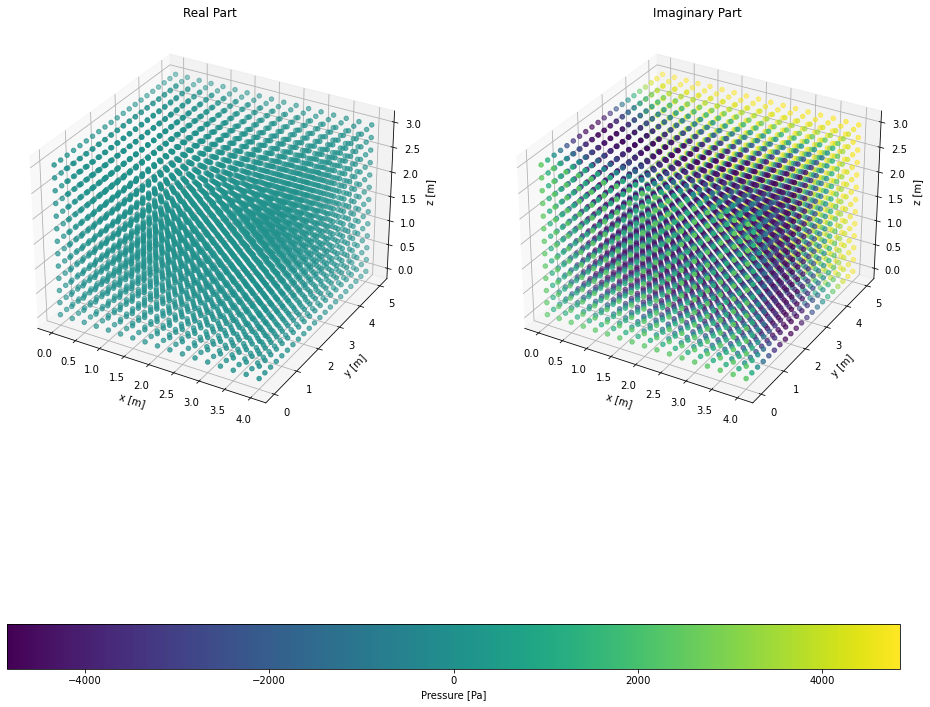

In [19]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 24)

max_pressure = max(np.max(np.abs(u_re_at_nodes)), np.max(np.abs(u_im_at_nodes)))


fig = plt.figure()

ax_re = fig.add_subplot(121, projection='3d')
scatter_plt = ax_re.scatter(nodes_re[:, 0], nodes_re[:, 1], nodes_re[:, 2], c=u_re_at_nodes, vmin=-max_pressure, vmax=max_pressure)

ax_im = fig.add_subplot(122, projection='3d')
ax_im.scatter(nodes_im[:, 0], nodes_im[:, 1], nodes_im[:, 2], c=u_im_at_nodes, vmin=-max_pressure, vmax=max_pressure)

ax_re.set_xlabel('x [m]')
ax_re.set_ylabel('y [m]')
ax_re.set_zlabel('z [m]')

ax_im.set_xlabel('x [m]')
ax_im.set_ylabel('y [m]')
ax_im.set_zlabel('z [m]')

ax_re.set_title('Real Part')
ax_im.set_title('Imaginary Part')

c_bar = fig.colorbar(scatter_plt, ax=[ax_re, ax_im], orientation="horizontal")
c_bar.set_label('Pressure [Pa]')

plt.show()

However, this plot is perhaps not the clearest. It shows the value of the fields at each node, but the features of the field are not easy to make out. Below we use [Plotly](https://plotly.com/python/) to make a more sophisticated iso-surfaces plot. We chose Plotly as it has a convenient `Isosurface` function (plus, it makes nice interactive plots, although they are a bit slow to compute). We will need to pack the arrays in a format that Plotly can parse. This operation is performed below with loops, as they are easy to understand. However, this approach is not very efficient. Better solutions are possible.

In [21]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm.auto import trange  # To keep track of progress

max_pressure = max(np.max(np.abs(u_re_at_nodes)), np.max(np.abs(u_im_at_nodes)))

# Let's first find all the unique values of the coordinates.
assert np.array_equal(nodes_im, nodes_re)  # The arrays are equal, so we need to use only one.
nodes_x_coords = np.unique(nodes_re[:, 0])
nodes_y_coords = np.unique(nodes_re[:, 1])
nodes_z_coords = np.unique(nodes_re[:, 2])

# We now compute a mesh grid of all these values. These arrays, flattened, are what Plotly wants.
gl_x, gl_y, gl_z = np.meshgrid(
    nodes_x_coords, 
    nodes_y_coords, 
    nodes_z_coords
)

# Of course, we need to pack the fields in the same format, so we first initialise the new fields.
# Then, we loop and assign each value into the correct slot.
assert gl_x.shape == gl_y.shape == gl_z.shape == (nodes_y_coords.size, nodes_x_coords.size, nodes_z_coords.size)
field_shape = (nodes_y_coords.size, nodes_x_coords.size, nodes_z_coords.size)
field_re = np.zeros(field_shape)
field_im = np.zeros(field_shape)

for ny in trange(field_shape[0], desc='Preparing Data for Plot...'):
    for nx in range(field_shape[1]):
        for nz in range(field_shape[2]):
            for node_row in range(nodes_im.shape[0]):
                if np.array_equal(
                    np.array([gl_x[ny, nx, nz], gl_y[ny, nx, nz], gl_z[ny, nx, nz]]), 
                    nodes_im[node_row, :]
                ):
                    field_re[ny, nx, nz] = u_re_at_nodes[node_row]
                    field_im[ny, nx, nz] = u_im_at_nodes[node_row]
                    break

Preparing Data for Plot...:   0%|          | 0/21 [00:00<?, ?it/s]

In [37]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scene"}, {"type": "scene"}]])

fig.add_trace(
    go.Isosurface(
        x=gl_x.flatten(),
        y=gl_y.flatten(),
        z=gl_z.flatten(),
        value=field_re.flatten(),
        isomin=-max_pressure,
        isomax=max_pressure,
        surface_count=3
    ),
    row=1,
    col=1
)

fig.add_trace(
    go.Isosurface(
        x=gl_x.flatten(),
        y=gl_y.flatten(),
        z=gl_z.flatten(),
        value=field_im.flatten(),
        isomin=-max_pressure,
        isomax=max_pressure,
        surface_count=3
    ),
    row=1,
    col=2
)

fig.show()


Many more plots are possible. For more information, refer to [Solving PDEs in Python](https://link.springer.com/book/10.1007/978-3-319-52462-7). We complete the tutorial by showing how to save the fields as `vtu` (even though we specify a `pvd` extension). These fields can be opened with [ParaView](https://www.paraview.org/), which allows advanced postprocessing in a GUI environment.

In [24]:
vtk_file_re = fenics.File('solution_re.pvd')
vtk_file_re << u_re

vtk_file_im = fenics.File('solution_im.pvd')
vtk_file_im << u_im

### A Comment About the Solution

You have probably noticed that the real part of the solution is pretty much 0 everywhere. This is to be expected because:

* The material is lossless;
* The flux is purely imaginary;

This can be kept in mind to accelerate simulation: no need to include the real parts in the bilinear and linear forms in this case!